# Train the network using the REDISAI db as an exchange place and debug the problems


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models
import torch.utils.data as tdata

import numpy as np
import redisai as rai

from dataclasses import dataclass
import pickle

import matplotlib.pyplot as plt
import pymongo

# Ip of minikube and the port of the mongo service
MONGO_IP = '192.168.99.101'
MONGO_PORT = 30933

# import the modules used in the program
import train_utils
import ml2rt

c:\users\diego\cs\thesis\venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\diego\cs\thesis\venv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\diego\cs\thesis\venv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Create the network

In [2]:
@dataclass
class TrainParams:
    ps_id: str
    N: int
    task: str
    func_id: int
    lr: float
    batch_size: int
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
def create_model(init: bool):
    """Creates the model used to train the network

    For this example we'll be using the simple model from the MNIST examples
    (https://github.com/pytorch/examples/blob/master/mnist/main.py)
    """

    def init_weights(m: nn.Module):
        """Initialize the weights of the network"""
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.01)
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.01)

    # Create the model and initialize the weights
    model = Net()

    # If the task is initializing the layers do so
    if init:
        print('Initializing layers...')
        model.apply(init_weights)

    return model

In [3]:
torch.cuda.is_available()

True

## Create the Dataloader

In [45]:

# TODO max document size is 16 MB, this could give us problems in the future
# when the datasets are so big, we should calculate the size (easy, and divide the dataset)
def split_dataset(X, Y, subsets):
    """Splits the X and Y in N different subsets"""
    X_split = np.split(X, subsets)
    Y_split = np.split(Y, subsets)
    
    return X_split, Y_split


def approx_size(a: np.array):
    """ approx size of float 32 array in MB"""
    return (32/8) * np.prod(a.shape) / 1e6



In [15]:
47*128, 16*128

(6016, 2048)

In [9]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_data = datasets.MNIST('./data', train=True, download=False, transform=transform)
val_data = datasets.MNIST('./data', train=False, download=False, transform=transform)

# train_data.data, train_data.targets = train_data.data[:3000], train_data.targets[:3000]
# val_data.data, val_data.targets = val_data.data[:2000], val_data.targets[:2000]

In [10]:

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)
len(train_loader), len(val_loader)

(1875, 313)

# Define the train and test methods


In [6]:
def train(model: nn.Module, device,
          train_loader: tdata.DataLoader,
          optimizer: torch.optim.Optimizer, tensor_dict) -> float:
    """Loop used to train the network"""
    model.train()
    loss, tot = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         print(data.shape, target.shape)
        optimizer.zero_grad()
        output = model(data)
        print(output.shape)

        loss = F.nll_loss(output, target)
        tot += loss.item()
        loss.backward()

        # Here save the gradients to publish on the database
#         train_utils.update_tensor_dict(model, tensor_dict)
        optimizer.step()
        

        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                1, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), loss.item()))

    return tot/len(train_loader)


def validate(model, device, val_loader: tdata.DataLoader) -> (float, float):
    """Loop used to validate the network"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)

    accuracy = 100. * correct / len(val_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return accuracy, test_loss

def infer(model, device, data: np.array):
    """Forward the data through the network and return the predictions"""
    model.eval()
    data = transform(data).to(device)
    data = data.permute(1, 2, 0).view(-1, 1, 28, 28)
    out = model(data)
    
    preds = torch.argmax(out, axis=1)
    return preds.cpu().numpy()
    
    

In [103]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

## Main entrypoint of the code

In [5]:
from copy import deepcopy

params = TrainParams(ps_id='example', func_id=0, N =2, task='train', lr=0.01, batch_size=128)


torch.manual_seed(42) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

# Create the model
model = create_model(init=True).to(device)

Initializing layers...


In [50]:
# Create the redis connection
addr = '192.168.99.101'
port = 31618
con = rai.Client(debug=True, host=addr, port=port)

### Train for a couple of epochs

In [11]:
%%time
# create the tensor dict
tdict = dict()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1,11):
    print('Epoch', epoch)
    train(model, device, train_loader, optimizer, tdict)
    validate(model, device, val_loader)


Epoch 1
torch.Size([32, 10])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321324
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [160/60000 (0%)]	Loss: 2.285880
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [320/60000 (1%)]	Loss: 1.965616
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [480/60000 (1%)]	Loss: 1.636451
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.197344
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [800/60000 (1%)]	Loss: 1.128333
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.190642
torch.Size([32

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.187971
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9120/60000 (15%)]	Loss: 0.238363
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9280/60000 (15%)]	Loss: 0.291456
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9440/60000 (16%)]	Loss: 0.468784
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.350593
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9760/60000 (16%)]	Loss: 0.678124
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([3

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.138026
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18080/60000 (30%)]	Loss: 0.192179
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18240/60000 (30%)]	Loss: 0.124674
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.318714
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18560/60000 (31%)]	Loss: 0.056762
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18720/60000 (31%)]	Loss: 0.109586
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

Train Epoch: 1 [26720/60000 (45%)]	Loss: 0.521478
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.474970
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27040/60000 (45%)]	Loss: 0.065069
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.065783
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27360/60000 (46%)]	Loss: 0.162472
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27520/60000 (46%)]	Loss: 0.036133
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27680/60000 (46%)]	Loss: 0.111625
torch.Size([32, 10])

torch.Size([32, 10])
Train Epoch: 1 [35520/60000 (59%)]	Loss: 0.044729
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [35680/60000 (59%)]	Loss: 0.127124
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.288903
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.180762
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36160/60000 (60%)]	Loss: 0.082379
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36320/60000 (61%)]	Loss: 0.091082
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.091866

Train Epoch: 1 [44160/60000 (74%)]	Loss: 0.023522
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44320/60000 (74%)]	Loss: 0.112510
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44480/60000 (74%)]	Loss: 0.161897
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44640/60000 (74%)]	Loss: 0.011029
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.187883
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44960/60000 (75%)]	Loss: 0.047759
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45120/60000 (75%)]	Loss: 0.112369
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53280/60000 (89%)]	Loss: 0.062898
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.250775
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53600/60000 (89%)]	Loss: 0.197970
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.136178
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53920/60000 (90%)]	Loss: 0.077654
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.139885
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.033906
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.234209
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.014262
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2720/60000 (5%)]	Loss: 0.333613
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.043047
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3040/60000 (5%)]	Loss: 0.103769
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10]

torch.Size([32, 10])
Train Epoch: 1 [10720/60000 (18%)]	Loss: 0.022889
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.039524
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11040/60000 (18%)]	Loss: 0.079684
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.072817
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11360/60000 (19%)]	Loss: 0.156738
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.088433
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11680/60000 (19%)]	Loss: 0.062316

Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.007478
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19360/60000 (32%)]	Loss: 0.501948
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19520/60000 (33%)]	Loss: 0.079312
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19680/60000 (33%)]	Loss: 0.024203
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19840/60000 (33%)]	Loss: 0.200100
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.147628
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20160/60000 (34%)]	Loss: 0.250630
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.227008
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.032479
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28320/60000 (47%)]	Loss: 0.029955
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28480/60000 (47%)]	Loss: 0.135527
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28640/60000 (48%)]	Loss: 0.304451
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.020227
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.049398
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36640/60000 (61%)]	Loss: 0.082514
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36800/60000 (61%)]	Loss: 0.051679
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36960/60000 (62%)]	Loss: 0.013168
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37120/60000 (62%)]	Loss: 0.144532
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37280/60000 (62%)]	Loss: 0.184110
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

Train Epoch: 1 [44960/60000 (75%)]	Loss: 0.108860
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45120/60000 (75%)]	Loss: 0.253351
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45280/60000 (75%)]	Loss: 0.026363
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.136615
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45600/60000 (76%)]	Loss: 0.128233
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45760/60000 (76%)]	Loss: 0.178380
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45920/60000 (77%)]	Loss: 0.039773
torch.Size([32, 10])

Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.050731
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53600/60000 (89%)]	Loss: 0.070460
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.058845
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53920/60000 (90%)]	Loss: 0.029518
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.204255
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54240/60000 (90%)]	Loss: 0.102205
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.005016
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.014169
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.236070
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.019290
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2720/60000 (5%)]	Loss: 0.288248
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.040451
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3040/60000 (5%)]	Loss: 0.177675
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10]

Train Epoch: 1 [10720/60000 (18%)]	Loss: 0.035107
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.016324
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11040/60000 (18%)]	Loss: 0.004882
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.252725
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11360/60000 (19%)]	Loss: 0.009758
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.091805
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [11680/60000 (19%)]	Loss: 0.091327
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19360/60000 (32%)]	Loss: 0.273989
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19520/60000 (33%)]	Loss: 0.017362
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19680/60000 (33%)]	Loss: 0.005034
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [19840/60000 (33%)]	Loss: 0.173234
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.114776
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20160/60000 (34%)]	Loss: 0.062191
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27840/60000 (46%)]	Loss: 0.178942
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.070818
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.205971
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28320/60000 (47%)]	Loss: 0.033109
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28480/60000 (47%)]	Loss: 0.032388
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28640/60000 (48%)]	Loss: 0.183346
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.055816
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36640/60000 (61%)]	Loss: 0.011748
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36800/60000 (61%)]	Loss: 0.011163
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36960/60000 (62%)]	Loss: 0.014632
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37120/60000 (62%)]	Loss: 0.059065
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37280/60000 (62%)]	Loss: 0.028996
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45120/60000 (75%)]	Loss: 0.080386
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45280/60000 (75%)]	Loss: 0.053734
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.071703
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45600/60000 (76%)]	Loss: 0.317204
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45760/60000 (76%)]	Loss: 0.143925
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [45920/60000 (77%)]	Loss: 0.055890
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54240/60000 (90%)]	Loss: 0.199611
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.011063
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54560/60000 (91%)]	Loss: 0.091190
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.009043
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54880/60000 (91%)]	Loss: 0.070801
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.078459
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

Train Epoch: 1 [2720/60000 (5%)]	Loss: 0.244860
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.056621
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3040/60000 (5%)]	Loss: 0.009987
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.173992
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3360/60000 (6%)]	Loss: 0.018764
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.041579
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3680/60000 (6%)]	Loss: 0.355828
torch.Size([32, 10])
torch.Size([3

Train Epoch: 1 [11840/60000 (20%)]	Loss: 0.008702
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.049602
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.126401
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12320/60000 (21%)]	Loss: 0.006345
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12480/60000 (21%)]	Loss: 0.035484
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12640/60000 (21%)]	Loss: 0.011814
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.058406
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.032772
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20640/60000 (34%)]	Loss: 0.093634
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.013454
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20960/60000 (35%)]	Loss: 0.070039
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21120/60000 (35%)]	Loss: 0.119215
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21280/60000 (35%)]	Loss: 0.018753
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [28960/60000 (48%)]	Loss: 0.061105
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29120/60000 (49%)]	Loss: 0.019855
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29280/60000 (49%)]	Loss: 0.170925
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.082963
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29600/60000 (49%)]	Loss: 0.009654
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29760/60000 (50%)]	Loss: 0.058177
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
Train Epoch: 1 [37440/60000 (62%)]	Loss: 0.161499
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37600/60000 (63%)]	Loss: 0.024895
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37760/60000 (63%)]	Loss: 0.004234
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37920/60000 (63%)]	Loss: 0.109010
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38080/60000 (63%)]	Loss: 0.005352
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38240/60000 (64%)]	Loss: 0.030903
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.227457

torch.Size([32, 10])
Train Epoch: 1 [45920/60000 (77%)]	Loss: 0.009828
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.155668
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46240/60000 (77%)]	Loss: 0.142891
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46400/60000 (77%)]	Loss: 0.267372
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46560/60000 (78%)]	Loss: 0.008248
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.127265
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46880/60000 (78%)]	Loss: 0.004301

Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.073125
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54560/60000 (91%)]	Loss: 0.049980
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.086484
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54880/60000 (91%)]	Loss: 0.069652
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.038082
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55200/60000 (92%)]	Loss: 0.012887
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.010683
torch.Size([32, 10])

torch.Size([32, 10])
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.099264
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3680/60000 (6%)]	Loss: 0.099070
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.001066
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.046066
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.029200
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4320/60000 (7%)]	Loss: 0.139248
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.023480
torch.Size([3

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.000972
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12320/60000 (21%)]	Loss: 0.000154
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12480/60000 (21%)]	Loss: 0.009675
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12640/60000 (21%)]	Loss: 0.036429
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.000876
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12960/60000 (22%)]	Loss: 0.006789
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20640/60000 (34%)]	Loss: 0.082171
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.014995
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [20960/60000 (35%)]	Loss: 0.081274
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21120/60000 (35%)]	Loss: 0.069220
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21280/60000 (35%)]	Loss: 0.065872
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21440/60000 (36%)]	Loss: 0.010502
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
Train Epoch: 1 [29120/60000 (49%)]	Loss: 0.034948
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29280/60000 (49%)]	Loss: 0.106858
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.041644
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29600/60000 (49%)]	Loss: 0.004746
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29760/60000 (50%)]	Loss: 0.065539
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [29920/60000 (50%)]	Loss: 0.015210
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [30080/60000 (50%)]	Loss: 0.023430

torch.Size([32, 10])
Train Epoch: 1 [37600/60000 (63%)]	Loss: 0.013336
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37760/60000 (63%)]	Loss: 0.006535
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [37920/60000 (63%)]	Loss: 0.013557
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38080/60000 (63%)]	Loss: 0.009279
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38240/60000 (64%)]	Loss: 0.016467
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.115144
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38560/60000 (64%)]	Loss: 0.078923

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46240/60000 (77%)]	Loss: 0.225655
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46400/60000 (77%)]	Loss: 0.228968
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46560/60000 (78%)]	Loss: 0.022528
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.085753
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [46880/60000 (78%)]	Loss: 0.002885
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [47040/60000 (78%)]	Loss: 0.009737
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [54880/60000 (91%)]	Loss: 0.008372
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.012914
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55200/60000 (92%)]	Loss: 0.002556
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.002663
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55520/60000 (93%)]	Loss: 0.004152
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.007817
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.121673
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3680/60000 (6%)]	Loss: 0.133426
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.023098
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.006367
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.072178
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4320/60000 (7%)]	Loss: 0.051685
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.002640
torch.Size([32, 10])
torch.Size([3

Train Epoch: 1 [12640/60000 (21%)]	Loss: 0.028114
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.019293
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [12960/60000 (22%)]	Loss: 0.035544
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [13120/60000 (22%)]	Loss: 0.039861
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [13280/60000 (22%)]	Loss: 0.001541
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.010444
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [13600/60000 (23%)]	Loss: 0.021548
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.001367
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [21920/60000 (37%)]	Loss: 0.008883
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22080/60000 (37%)]	Loss: 0.025253
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22240/60000 (37%)]	Loss: 0.056805
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.005221
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22560/60000 (38%)]	Loss: 0.251212
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

Train Epoch: 1 [30240/60000 (50%)]	Loss: 0.009765
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [30400/60000 (51%)]	Loss: 0.001742
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [30560/60000 (51%)]	Loss: 0.005215
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.052172
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [30880/60000 (51%)]	Loss: 0.025107
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31040/60000 (52%)]	Loss: 0.020237
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31200/60000 (52%)]	Loss: 0.003143
torch.Size([32, 10])

Train Epoch: 1 [38720/60000 (65%)]	Loss: 0.007780
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [38880/60000 (65%)]	Loss: 0.003644
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [39040/60000 (65%)]	Loss: 0.002970
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [39200/60000 (65%)]	Loss: 0.000248
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [39360/60000 (66%)]	Loss: 0.206678
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [39520/60000 (66%)]	Loss: 0.028013
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [39680/60000 (66%)]	Loss: 0.035445
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [47520/60000 (79%)]	Loss: 0.118650
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [47680/60000 (79%)]	Loss: 0.058566
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [47840/60000 (80%)]	Loss: 0.002290
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.076009
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [48160/60000 (80%)]	Loss: 0.003499
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [48320/60000 (81%)]	Loss: 0.019276
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.074601
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56160/60000 (94%)]	Loss: 0.141388
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.007534
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56480/60000 (94%)]	Loss: 0.005511
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.014609
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56800/60000 (95%)]	Loss: 0.083976
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [56960/60000 

torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [4960/60000 (8%)]	Loss: 0.036485
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.082511
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [5280/60000 (9%)]	Loss: 0.021312
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.007349
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [5600/60000 (9%)]	Loss: 0.085343
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.002562
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [5920/60000 (10%)]	Loss:

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [13760/60000 (23%)]	Loss: 0.000770
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [13920/60000 (23%)]	Loss: 0.007859
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001071
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [14240/60000 (24%)]	Loss: 0.002718
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.007399
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [14560/60000 (24%)]	Loss: 0.098980
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22560/60000 (38%)]	Loss: 0.110297
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22720/60000 (38%)]	Loss: 0.010361
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [22880/60000 (38%)]	Loss: 0.001266
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.003104
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [23200/60000 (39%)]	Loss: 0.011931
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [23360/60000 (39%)]	Loss: 0.044527
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31200/60000 (52%)]	Loss: 0.000218
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31360/60000 (52%)]	Loss: 0.039672
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31520/60000 (53%)]	Loss: 0.010672
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31680/60000 (53%)]	Loss: 0.000439
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [31840/60000 (53%)]	Loss: 0.060723
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.012926
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
Train Epoch: 1 [39840/60000 (66%)]	Loss: 0.016645
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.012960
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [40160/60000 (67%)]	Loss: 0.008231
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [40320/60000 (67%)]	Loss: 0.005722
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [40480/60000 (67%)]	Loss: 0.027727
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [40640/60000 (68%)]	Loss: 0.077865
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [40800/60000 (68%)]	Loss: 0.004562

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.183849
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [48800/60000 (81%)]	Loss: 0.008957
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [48960/60000 (82%)]	Loss: 0.156564
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [49120/60000 (82%)]	Loss: 0.131140
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.001376
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [49440/60000 (82%)]	Loss: 0.001690
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.059326
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [57760/60000 (96%)]	Loss: 0.110959
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.112523
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [58080/60000 (97%)]	Loss: 0.020459
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.110384
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [58400/60000 (97%)]	Loss: 0.003009
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [6080/60000 (10%)]	Loss: 0.009643
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [6240/60000 (10%)]	Loss: 0.031846
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.019569
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [6560/60000 (11%)]	Loss: 0.020110
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [6720/60000 (11%)]	Loss: 0.020794
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [6880/60000 (11%)]	Loss: 0.002809
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [14880/60000 (25%)]	Loss: 0.047968
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [15040/60000 (25%)]	Loss: 0.069480
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [15200/60000 (25%)]	Loss: 0.012816
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001997
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [15520/60000 (26%)]	Loss: 0.000448
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [15680/60000 (26%)]	Loss: 0.000069
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [23680/60000 (39%)]	Loss: 0.163259
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [23840/60000 (40%)]	Loss: 0.100188
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.093678
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [24160/60000 (40%)]	Loss: 0.009462
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001086
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [24480/60000 (41%)]	Loss: 0.004116
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

Train Epoch: 1 [32320/60000 (54%)]	Loss: 0.309375
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [32480/60000 (54%)]	Loss: 0.010858
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [32640/60000 (54%)]	Loss: 0.089514
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [32800/60000 (55%)]	Loss: 0.003933
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [32960/60000 (55%)]	Loss: 0.000038
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [33120/60000 (55%)]	Loss: 0.005344
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.001578
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [41440/60000 (69%)]	Loss: 0.160100
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.016378
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [41760/60000 (70%)]	Loss: 0.002570
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [41920/60000 (70%)]	Loss: 0.018109
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [42080/60000 (70%)]	Loss: 0.003257
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [42240/60000 (70%)]	Loss: 0.006283
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.S

Train Epoch: 1 [50240/60000 (84%)]	Loss: 0.000797
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [50400/60000 (84%)]	Loss: 0.007136
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.001810
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [50720/60000 (85%)]	Loss: 0.015363
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [50880/60000 (85%)]	Loss: 0.053225
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51040/60000 (85%)]	Loss: 0.000476
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.019151
torch.Size([32, 10])

torch.Size([32, 10])
Train Epoch: 1 [59040/60000 (98%)]	Loss: 0.000553
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [59200/60000 (99%)]	Loss: 0.000051
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [59360/60000 (99%)]	Loss: 0.004511
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.000772
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [59680/60000 (99%)]	Loss: 0.241910
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [59840/60000 (100%)]	Loss: 0.000064
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])

Test set: Average loss: 0.0321, Accuracy: 9911/10000 (99%)

Epoch 9


torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.000792
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [7840/60000 (13%)]	Loss: 0.005413
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.003457
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8160/60000 (14%)]	Loss: 0.000016
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.020407
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8480/60000 (14%)]	Loss: 0.008546
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 

torch.Size([32, 10])
Train Epoch: 1 [16160/60000 (27%)]	Loss: 0.082781
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [16320/60000 (27%)]	Loss: 0.006445
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [16480/60000 (27%)]	Loss: 0.001476
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.004447
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [16800/60000 (28%)]	Loss: 0.000323
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [16960/60000 (28%)]	Loss: 0.004648
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [17120/60000 (29%)]	Loss: 0.000331

torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [25280/60000 (42%)]	Loss: 0.062665
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [25440/60000 (42%)]	Loss: 0.002215
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.006106
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [25760/60000 (43%)]	Loss: 0.001638
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [25920/60000 (43%)]	Loss: 0.001358
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [26080/60000 (43%)]	Loss: 0.002065
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [26240/60000 

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [33920/60000 (57%)]	Loss: 0.000297
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [34080/60000 (57%)]	Loss: 0.031775
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [34240/60000 (57%)]	Loss: 0.000130
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.031794
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [34560/60000 (58%)]	Loss: 0.011383
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [34720/60000 (58%)]	Loss: 0.144493
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [42400/60000 (71%)]	Loss: 0.084040
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [42560/60000 (71%)]	Loss: 0.188052
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [42720/60000 (71%)]	Loss: 0.019287
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [42880/60000 (71%)]	Loss: 0.034095
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [43040/60000 (72%)]	Loss: 0.024749
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [43200/60000 (72%)]	Loss: 0.022993
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

Train Epoch: 1 [50880/60000 (85%)]	Loss: 0.014685
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51040/60000 (85%)]	Loss: 0.000692
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115178
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51360/60000 (86%)]	Loss: 0.000211
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51520/60000 (86%)]	Loss: 0.020411
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51680/60000 (86%)]	Loss: 0.020372
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.011263
torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [59840/60000 (100%)]	Loss: 0.001039
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])

Test set: Average loss: 0.0318, Accuracy: 9905/10000 (99%)

Epoch 10
torch.Size([32, 10])
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.000928
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [160/60000 (0%)]	Loss: 0.016324
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [320/60000 (1%)]	Loss: 0.060077
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [480/60000 (1%)]	Loss: 0.209036
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.003641
torch.Size([32, 10])
torch.Size([32, 

torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.003756
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8480/60000 (14%)]	Loss: 0.039467
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8640/60000 (14%)]	Loss: 0.004343
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8800/60000 (15%)]	Loss: 0.000192
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.057282
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9120/60000 (15%)]	Loss: 0.013953
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [9280/60000 (15%)]	

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [17440/60000 (29%)]	Loss: 0.004218
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.013795
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [17760/60000 (30%)]	Loss: 0.011059
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001566
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18080/60000 (30%)]	Loss: 0.005541
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [18240/60000 (30%)]	Loss: 0.043729
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [26560/60000 (44%)]	Loss: 0.281747
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [26720/60000 (45%)]	Loss: 0.172644
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.008995
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27040/60000 (45%)]	Loss: 0.003710
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.002141
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [27360/60000 (46%)]	Loss: 0.000158
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [35680/60000 (59%)]	Loss: 0.001117
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.030853
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.011283
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36160/60000 (60%)]	Loss: 0.001602
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36320/60000 (61%)]	Loss: 0.004635
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.119881
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44160/60000 (74%)]	Loss: 0.002711
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44320/60000 (74%)]	Loss: 0.003111
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44480/60000 (74%)]	Loss: 0.190929
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44640/60000 (74%)]	Loss: 0.000211
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.016221
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [44960/60000 (75%)]	Loss: 0.001369
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.000097
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53280/60000 (89%)]	Loss: 0.022726
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.208020
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53600/60000 (89%)]	Loss: 0.000634
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.003328
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train Epoch: 1 [53920/60000 (90%)]	Loss: 0.019086
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Train E

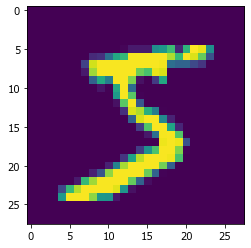

In [130]:
plt.imshow(train_data.data[0].numpy().squeeze())

torch.Size([6, 28, 28])
torch.Size([6, 1, 28, 28])
torch.Size([6, 1, 28, 28])


tensor([5, 0, 4, 1, 4, 2], device='cuda:0')

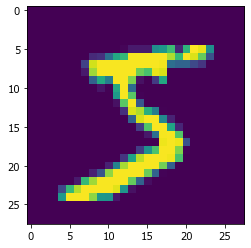

In [133]:
input_test = np.random.rand(28, 28, 2).astype('float32')
data = train_data.data[:6].numpy()
t = transform(data).to(device)
t = t.permute(1, 2, 0)
print(t.shape)
t = t.view(-1, 1, 28, 28)
print(t.shape)

plt.imshow(t[0].cpu().numpy().squeeze())
print(t.shape)
# t = torch.Tensor(input_test).to(device)
# out = model(t)
out=model.forward(t)

a = np.array([4], dtype='int64')
target = torch.as_tensor(a).to(device)
pred = torch.argmax(out, axis=1)
pred

In [176]:
t = train_data.data[:10].numpy()
infer(model, device, t)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
p = pickle.dumps(model.state_dict())


In [159]:
model.cpu().state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0710,  0.1848,  0.0198],
                        [-0.2222, -0.1628, -0.2172],
                        [-0.0973, -0.0572, -0.1459]]],
              
              
                      [[[-0.1846, -0.0205, -0.0799],
                        [-0.0126,  0.0830, -0.2512],
                        [-0.0528, -0.1518, -0.0973]]],
              
              
                      [[[-0.1700,  0.0730,  0.1478],
                        [-0.2474,  0.1059,  0.2154],
                        [-0.0067, -0.2537, -0.1290]]],
              
              
                      [[[ 0.0379, -0.0428, -0.1682],
                        [-0.0059,  0.0958, -0.0359],
                        [ 0.0487, -0.0123,  0.0376]]],
              
              
                      [[[-0.1336,  0.0980,  0.1453],
                        [ 0.0606,  0.1253,  0.0542],
                        [-0.0262,  0.0133,  0.1075]]],
              
              
               

In [223]:
model = model.to(device)

## Save the model in the database

In [150]:
client = pymongo.MongoClient(MONGO_IP, MONGO_PORT)

In [216]:
db = client['kubeml']
db.drop_collection('network')

{'nIndexesWas': 1, 'ns': 'kubeml.network', 'ok': 1.0}

In [217]:
db['network'].insert_one(
    {
        "_id": "test",
        "state_dict": pickle.dumps(model.cpu().state_dict())
}).inserted_id

'test'

In [172]:
res = db['network'].find_one({"_id": "test"})
model.load_state_dict(pickle.loads(res['state']))

<All keys matched successfully>

# Invoke the function with some data

In [200]:
import requests
import json

ROUTER_ADDRESS = "http://192.168.99.101:32422"
FUNCTION = "network"

In [237]:
data = train_data.data[0].numpy().tolist()
# data = np.array(data, dtype='uint8')
# infer(model, device, data)

In [245]:
js = json.dumps({"data":data})
with open('example.json', 'w') as f:
    f.write(js)

In [246]:
# send the request 
# url = "http://192.168.99.101:32422/inference?N=1&batchSize=128&funcId=0&lr=0.01&psId=test&task=infer"
url = "http://192.168.99.101:32422/network?N=1&batchSize=0&funcId=0&lr=1&psId=test&task=infer"


In [247]:
res = requests.post(url, json={"data": data })

In [205]:
res = requests.get(url)

In [248]:
res.json()['predictions']

[5]